In [ ]:
print('hello')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import skimage as sk
import skimage.io as skio
import cv2

In [26]:
# name of the input file
imname = './data/tobolsk.jpg'

# read in the image
im = skio.imread(imname)

In [27]:
# compute the height of each part (just 1/3 of total)
height = np.floor(im.shape[0] / 3.0).astype(int)

# separate color channels
b = im[:height]
g = im[height: 2*height]
r = im[2*height: 3*height]

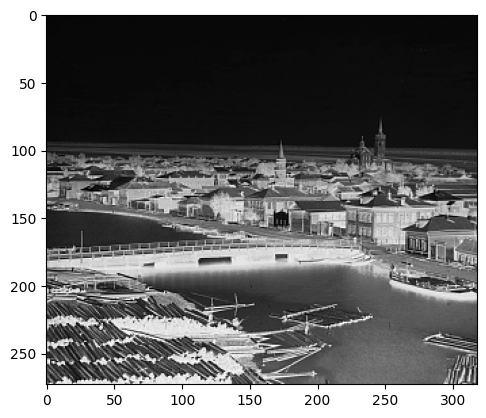

In [194]:
v_border = int(r.shape[0]*0.1)
h_border = int(r.shape[1]*0.1)
r_cropped = r[v_border:-v_border, h_border:-h_border]
b_cropped = b[v_border:-v_border, h_border:-h_border]
g_cropped = g[v_border:-v_border, h_border:-h_border]
rgb = np.array([r_cropped, g_cropped, b_cropped])
plt.imshow(rgb[2], cmap='gray_r')

3
144.0
198.0
198.0


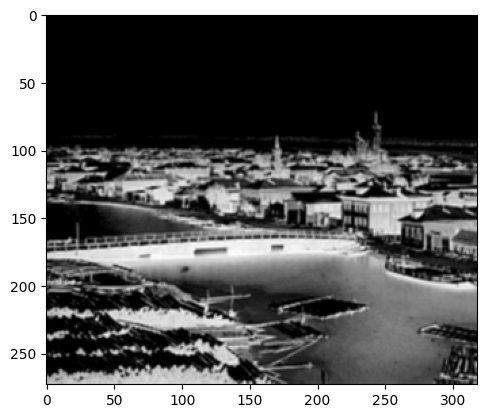

In [222]:
rgb_adj = np.empty_like(rgb)
kernel = np.floor(rgb[0].shape[0] * 0.01).astype(int)
kernel = kernel + 1 if kernel % 2 == 0 else kernel
print(kernel)

for i in range(0, 3):
    img_adj = rgb[i]
    white_point = np.percentile(img_adj, 50)
    print(white_point)
    img_adj = np.clip(img_adj + (255 - white_point), 0, 255).astype(np.uint8)
    
    # img_adj = 255 - img_adj
    # img_adj = cv2.convertScaleAbs(img_adj, alpha = 1.5, beta = -50)
    # img_adj = 255 - img_adj
    
    img_adj = cv2.GaussianBlur(img_adj, (kernel, kernel), 0)
    rgb_adj[i] = img_adj
    
plt.imshow(rgb_adj[0], cmap='gray_r')

In [249]:
low = 100
high = 400
lines = np.empty_like(rgb_adj)
for i in range(0, lines.shape[0]):
    edge = cv2.Canny(image=rgb_adj[i], threshold1=low, threshold2=high)
    # edge = cv2.GaussianBlur(edge, (kernel, kernel), 0)
    lines[i] = edge

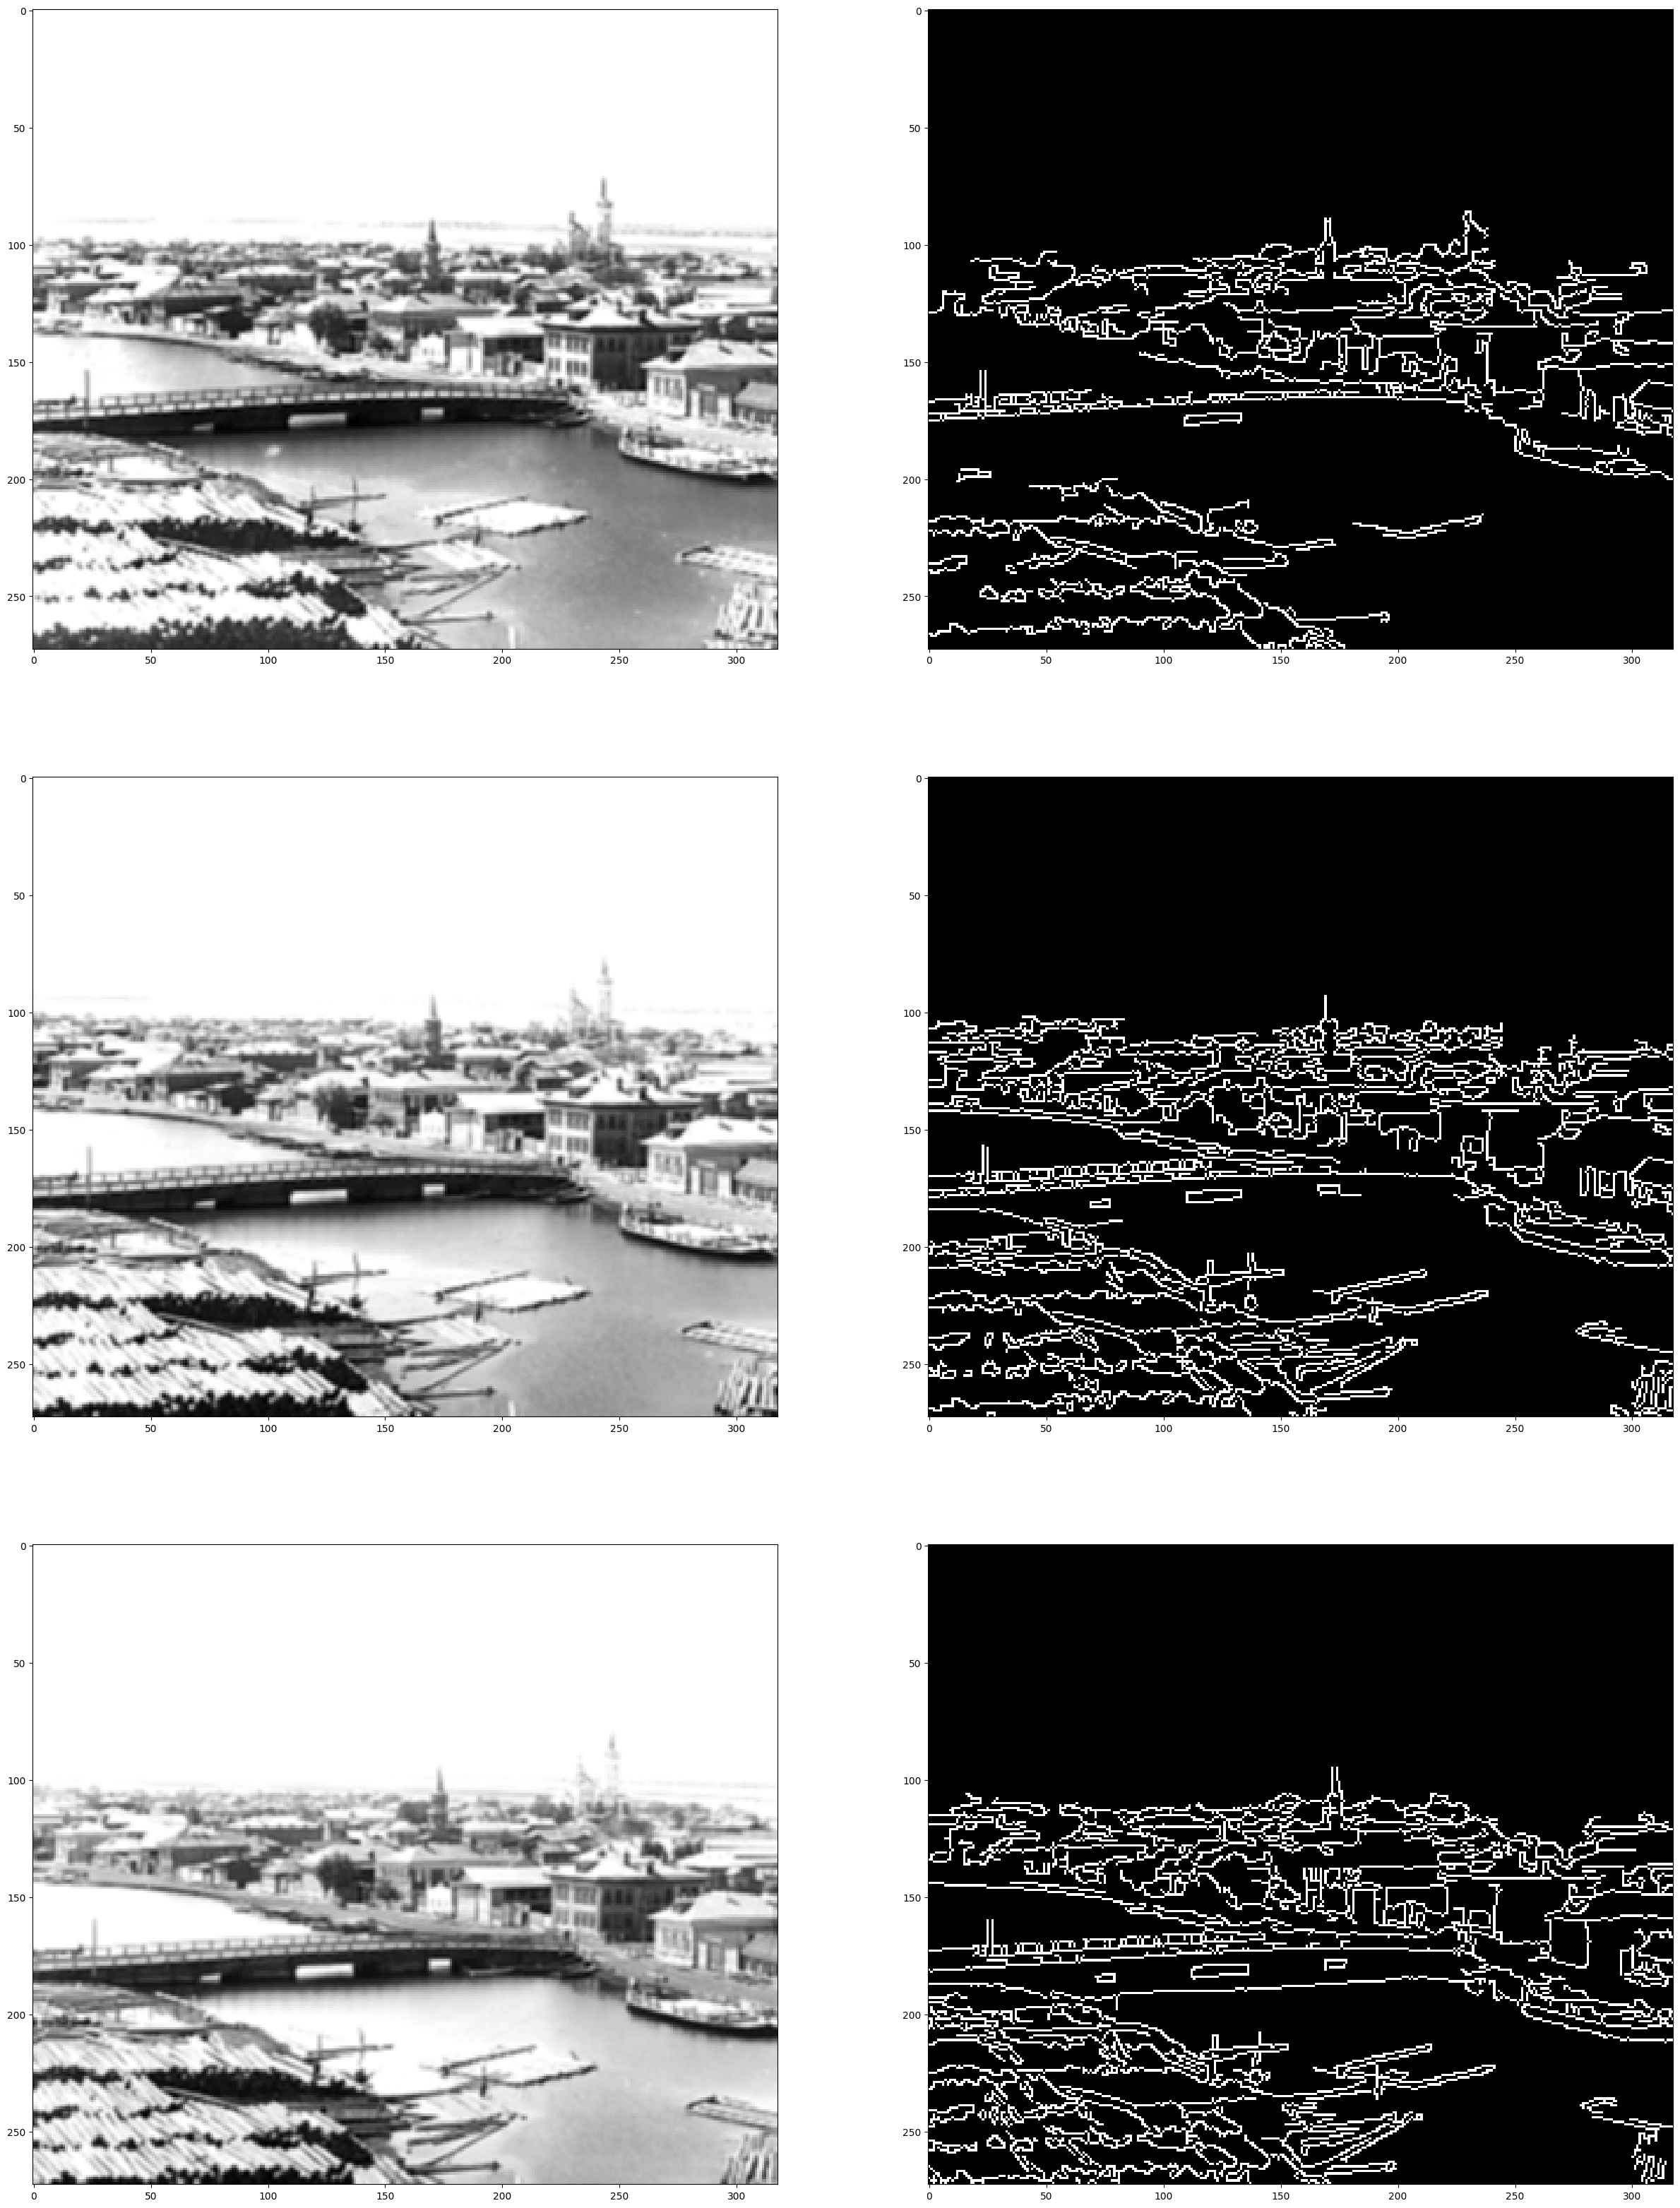

In [250]:
fig, axs = plt.subplots(3, 2, figsize=(30, 40))

for i in range(0, lines.shape[0]):
    axs[i,0].imshow(rgb_adj[i], cmap='gray')
    axs[i,1].imshow(lines[i], cmap='gray')

In [251]:
lineSum = np.sum(lines, axis=(1,2))
sortedLineSumIdx = np.flip(np.argsort(lineSum))
padding = np.floor(lines.shape[1]*0.05).astype(int)
paddedMaxLine = np.pad(lines[sortedLineSumIdx[0]], padding, mode='constant', constant_values=0)
print(sortedLineSumIdx)

[1 2 0]


13
(299, 344)


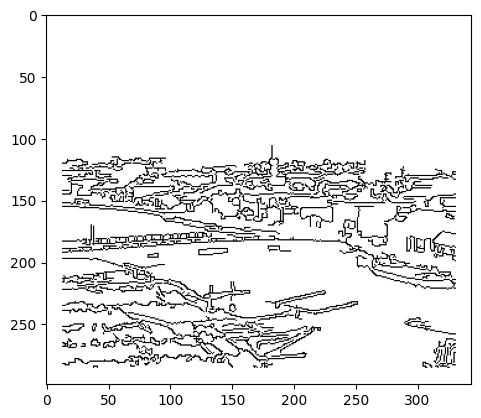

In [252]:
print(padding)
print(paddedMaxLine.shape)
plt.imshow(paddedMaxLine, cmap='gray_r')

[[13, 13], [10, 10], [13, 17]]


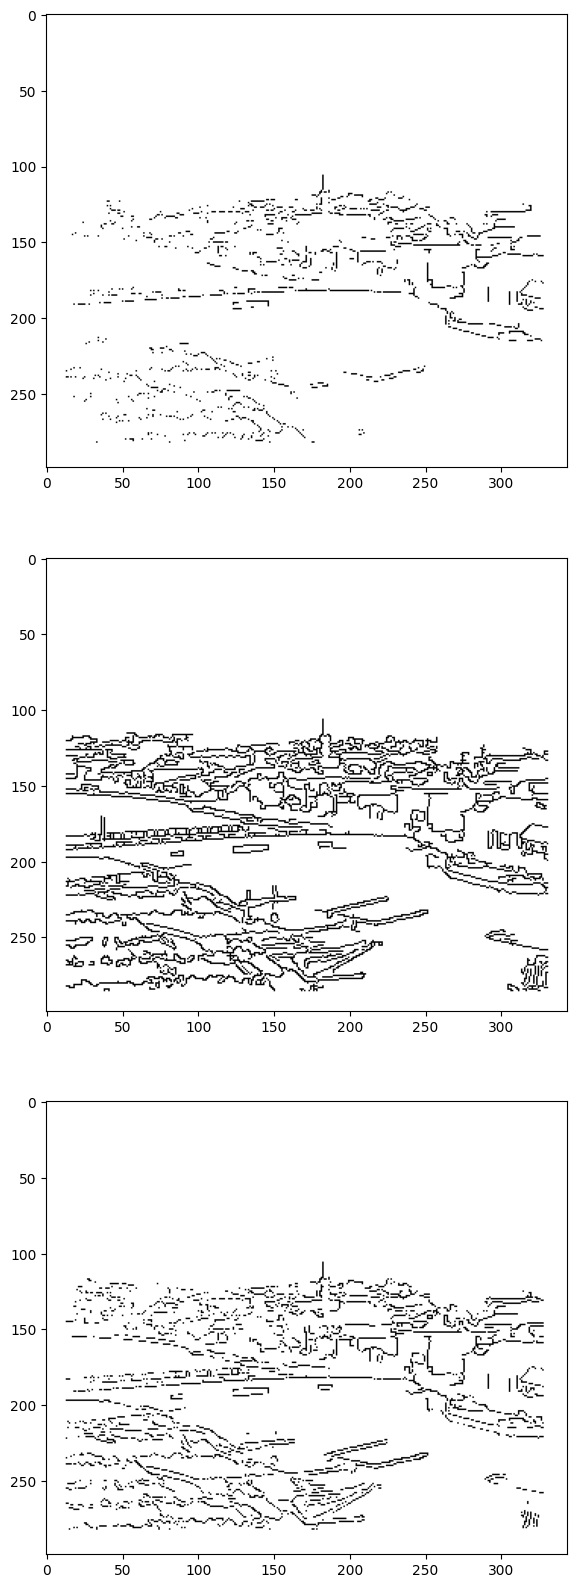

In [254]:
maxLine = paddedMaxLine
totalPadding = padding * 2
paddingOffset = []

fig, axs = plt.subplots(3, 1, figsize=(20, 20))
for i in sortedLineSumIdx:
    maxOverlapSum = 0
    maxOverlap = None
    maxX, maxY = 0, 0
    for y in range(0, totalPadding):
        for x in range(0, totalPadding):
            paddedLine = np.pad(lines[i], ((y, totalPadding-y), (x, totalPadding-x)), mode='constant', constant_values=1)
            imgOverlap = np.logical_and(maxLine, paddedLine).astype(np.uint8)
            imgOverlapSum = np.sum(imgOverlap)
            if imgOverlapSum > maxOverlapSum:
                maxOverlap = imgOverlap
                maxOverlapSum = imgOverlapSum
                maxX, maxY = x, y
                
    paddingOffset.append([maxX, maxY])
    color = np.pad(lines[i], ((maxY, totalPadding-maxY), (maxX, totalPadding-maxX)), mode='constant', constant_values=0)
    combinedImg = np.logical_and(maxLine, color).astype(np.uint8)
    maxLine = combinedImg
    axs[i].imshow(combinedImg, cmap='gray_r')
    
print(paddingOffset)

In [255]:
topLeftCorner = np.max(paddingOffset, axis=0)
bottomRightCorner = np.min(paddingOffset, axis=0) + [lines.shape[2], lines.shape[1]]

print(topLeftCorner, bottomRightCorner)

[13 17] [328 283]


(3, 299, 344)


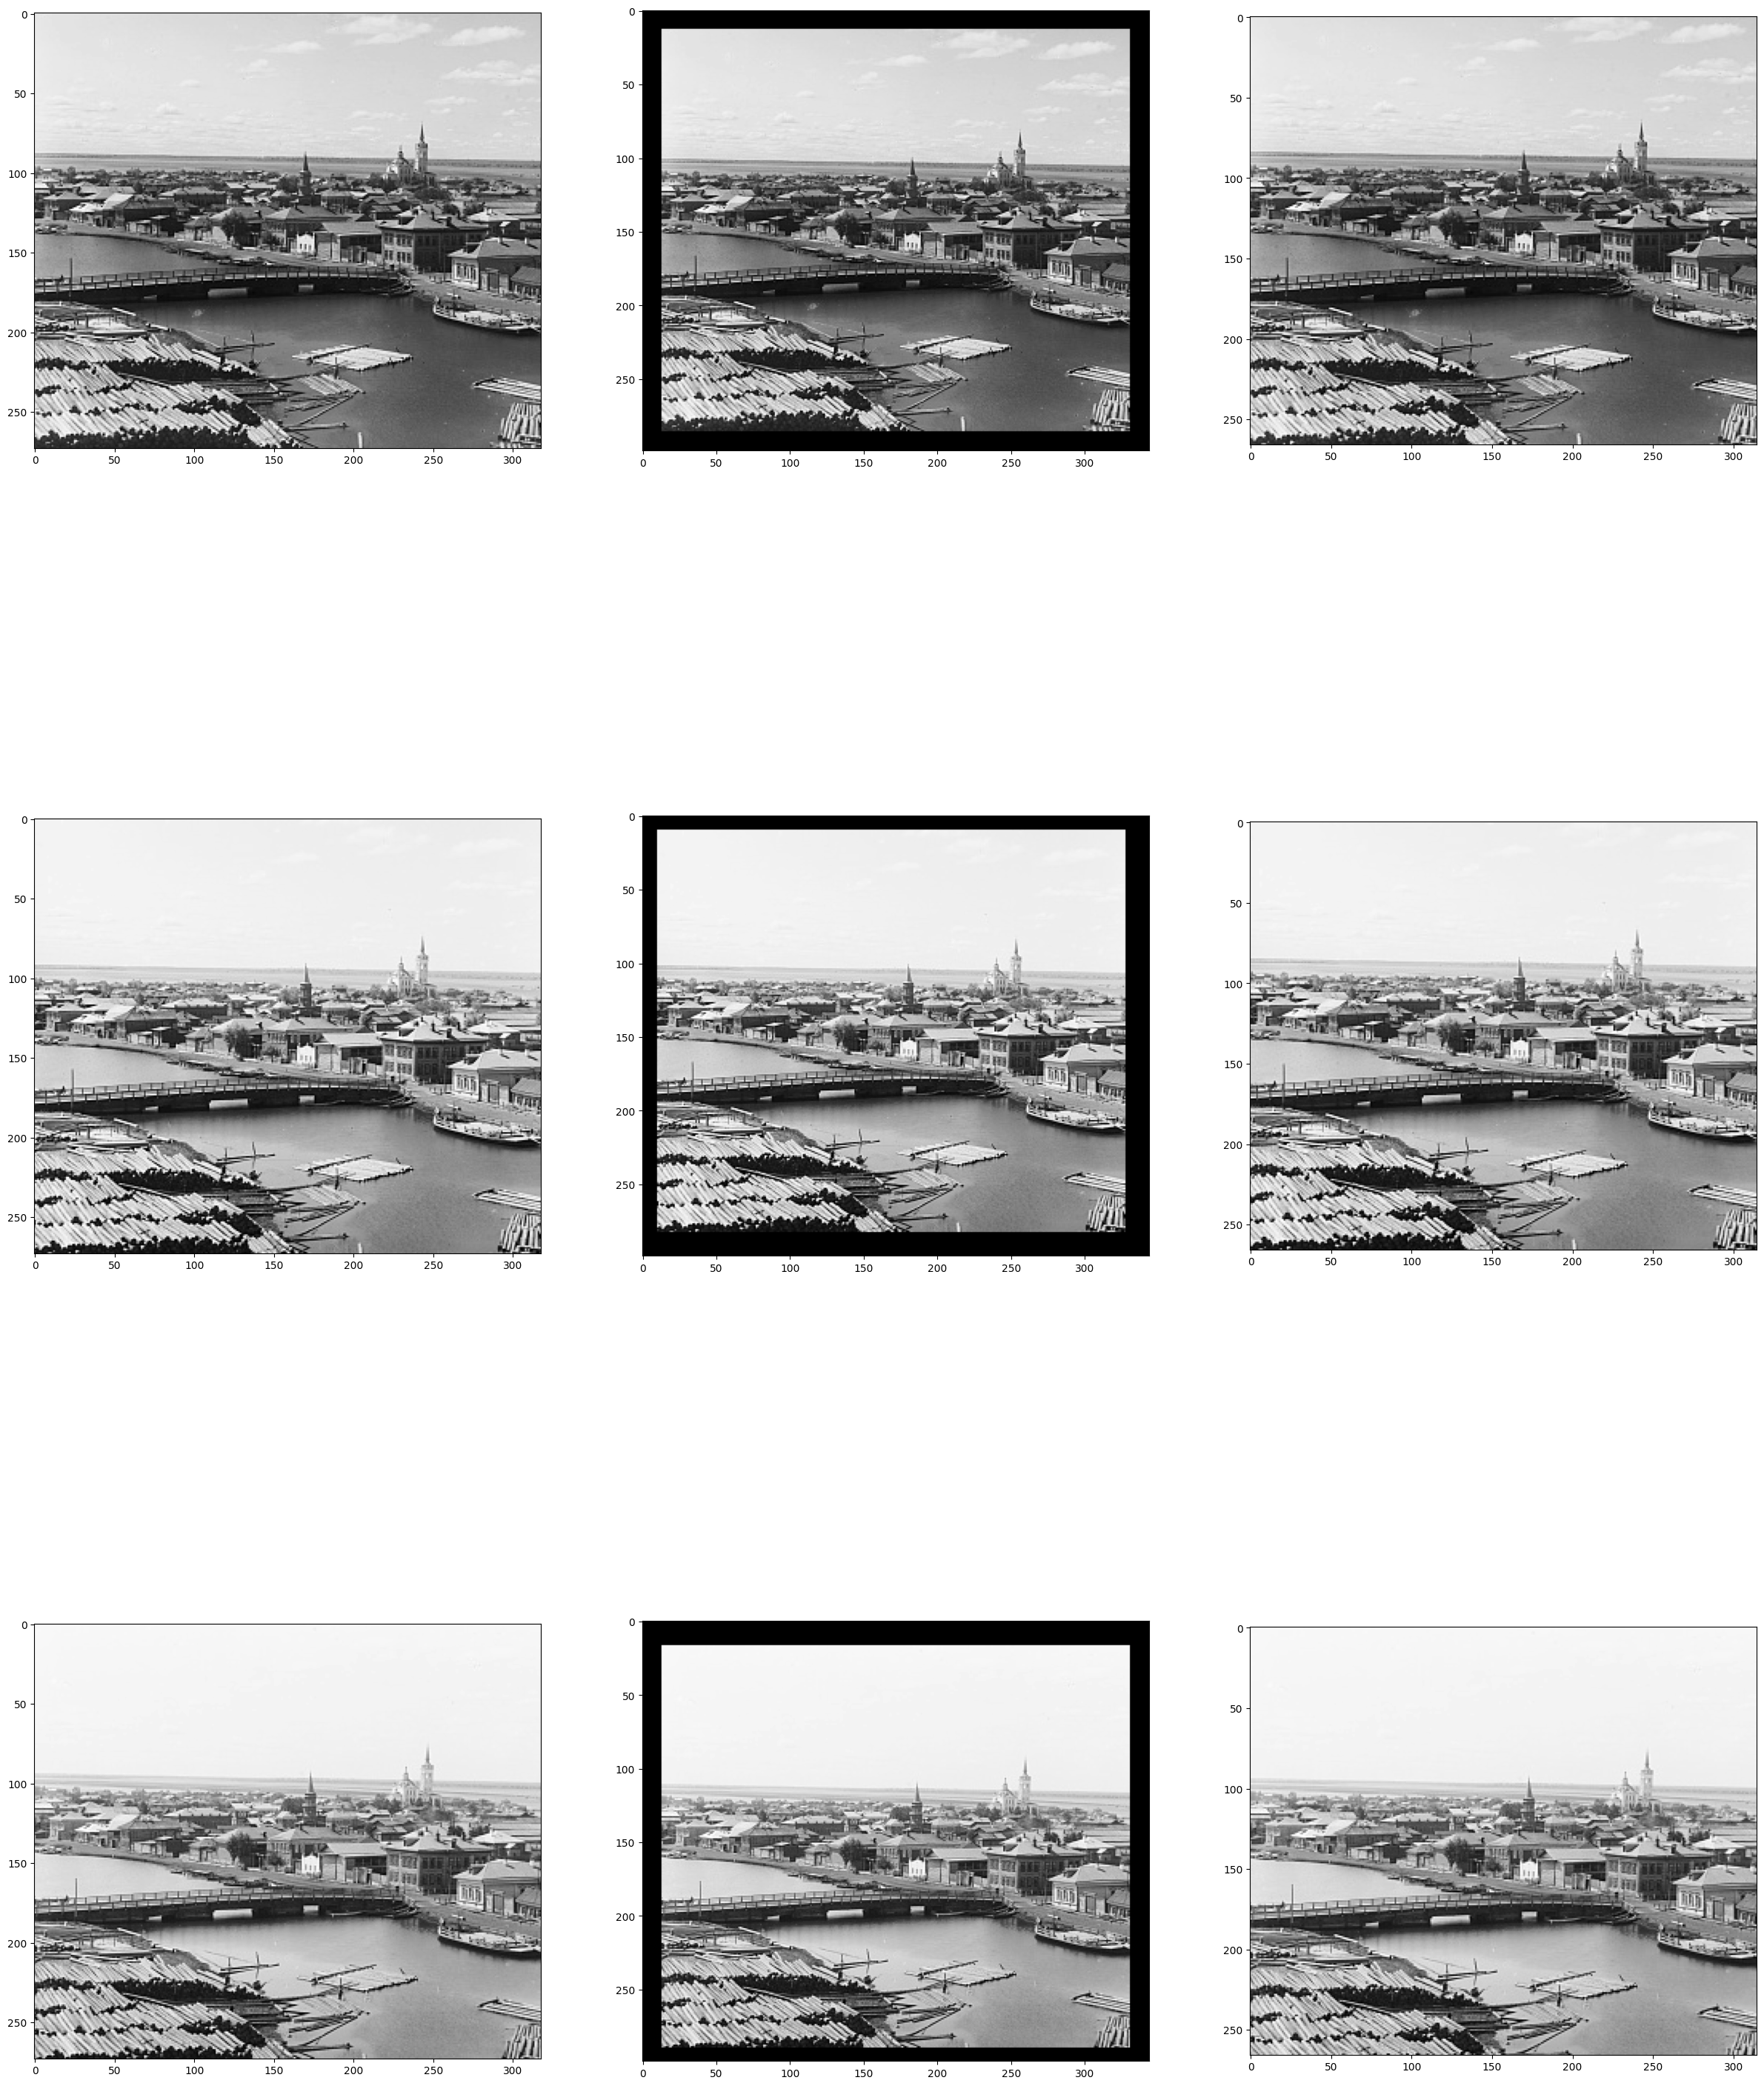

In [256]:
#Pad greyscale images
color_padded = np.empty((3, paddedMaxLine.shape[0], paddedMaxLine.shape[1]))
print(color_padded.shape)
totalPadding = padding * 2
for idx in sortedLineSumIdx:
    xyPad = paddingOffset[idx]
    color_padded[idx] = np.pad(rgb[idx], ((xyPad[1], totalPadding - xyPad[1]), (xyPad[0], totalPadding - xyPad[0])), mode='constant', constant_values=0)

color_padded = color_padded.astype(np.uint8)
# color_padded[0]
color_cropped = color_padded[:, topLeftCorner[1]:bottomRightCorner[1], topLeftCorner[0]:bottomRightCorner[0]]
# color_cropped[0]
fig, axs = plt.subplots(3, 3, figsize=(30, 40))
for i in range(0, lines.shape[0]):
    axs[i, 0].imshow(rgb[i], cmap='gray', vmin=0, vmax=255)
    axs[i, 1].imshow(color_padded[i], cmap='gray', vmin=0, vmax=255)
    axs[i, 2].imshow(color_cropped[i], cmap='gray', vmin=0, vmax=255)

In [84]:
colored = np.stack((color_cropped[0], color_cropped[1], color_cropped[2]), axis=2)

In [85]:
colored.shape

(270, 315, 3)

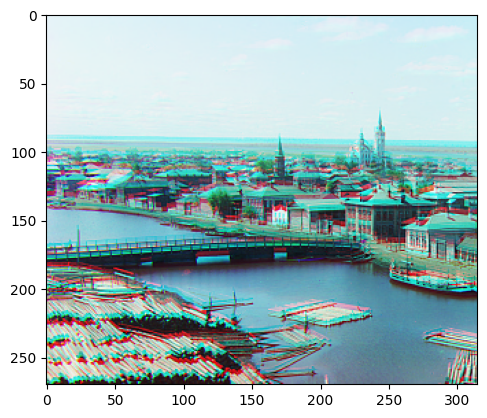

In [86]:
plt.imshow(colored)